In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima


# Auto-regressive integrated moving average models

## Introduction
ARIMA stands for Auto-Regressive Integrated Moving Average. Let's go through each one of these concepts one by one. 

### Auto-regressive
$$y_t = c + \rho_1  y_{t-1} + \rho_2  y_{t-2} + e_t$$

The autoregressive part of the model assumes that the best way to explain the current value in a time series is using a set number of the past observations. In this case, we are looking at a AR(2) model, and $\rho_1$ and $\rho_2$ are the parameters of interest for the model. 

### Moving average
The moving average component assumes that the best explanation for a time series is the error term of the previous values in the series:
$$y_t = c + \mu_1  e_{t-1} + \mu_1  e_{t-2} + e_t$$

This would be a MA(2) model, and $\mu_1$ and $\mu_2$ are the parameters of interest of the model. 

### Integrated
This value determines the amount of times we differenciate the series ($y_t-y_{t-1}$) for the AR and MA models above. 

The final equation depends on the integrated term. 
For more information on the functional form of the seasonal ARIMA, please check the `statsmodel` documentation. 







The parameters we are going to use below are $p$ for the AR component, $d$ for the integrated component, and $q$ for the MA component. 



# Data processing

In [3]:
# For this tutorial we are going to use the CO2 data available in the 
# Statsmodel package
data = sm.datasets.co2.load_pandas()
y = data.data
y.head(25)

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
1958-05-03,316.9
1958-05-10,NaN
1958-05-17,317.5
1958-05-24,317.9
1958-05-31,NaN


In [4]:
# We would like to reorganise the dataset in monthly data.
# The .resample() function indexes the data 
# M for monthly data, S for start of the month
# Since there is more than one observation for every month, we consider the mean
y = y['co2'].resample('MS').mean()
y.head(25)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
1958-08-01    314.950000
1958-09-01    313.500000
1958-10-01           NaN
1958-11-01    313.425000
1958-12-01    314.700000
1959-01-01    315.500000
1959-02-01    316.700000
1959-03-01    316.733333
1959-04-01    317.675000
1959-05-01    318.325000
1959-06-01    318.025000
1959-07-01    316.525000
1959-08-01    314.900000
1959-09-01    313.825000
1959-10-01    313.400000
1959-11-01    314.875000
1959-12-01    315.525000
1960-01-01    316.380000
1960-02-01    316.975000
1960-03-01    317.575000
Freq: MS, Name: co2, dtype: float64

In [5]:
# There are still some missing values. We are going to fill them 
# using the last available value. There are other possibilities, but that 
# is not the focus of this session
y = y.fillna(y.bfill())

y.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

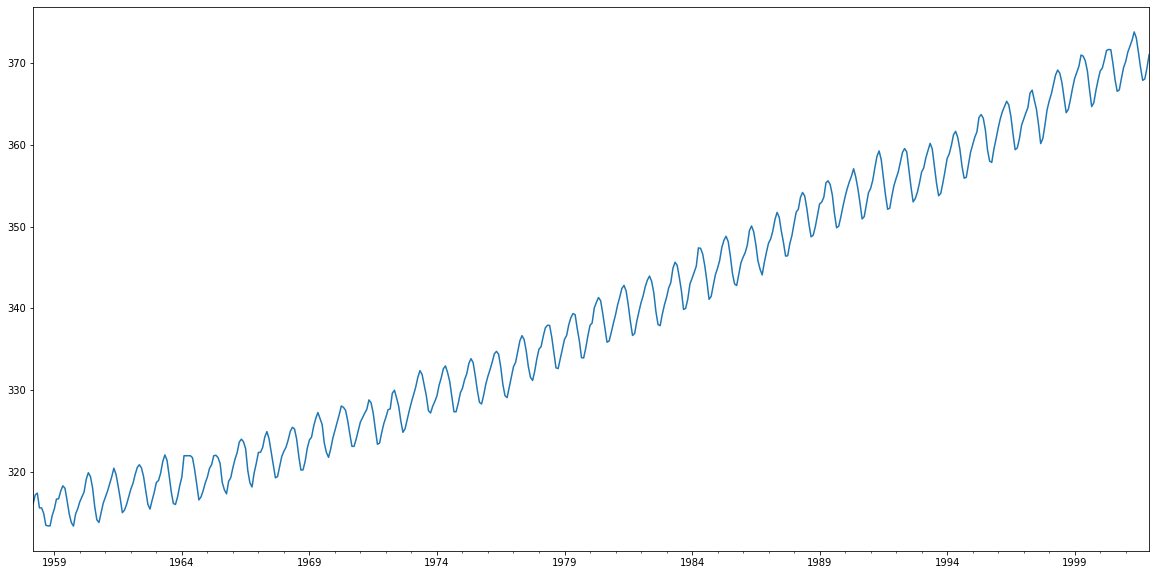

In [6]:
y.plot(figsize=(20, 10))
plt.show()

In [7]:
print("p-value:", adfuller(y.dropna())[1])

p-value: 0.9989901230798025


In [8]:
print("p-value:", adfuller(y.diff().dropna())[1])

p-value: 1.6614851317687864e-05


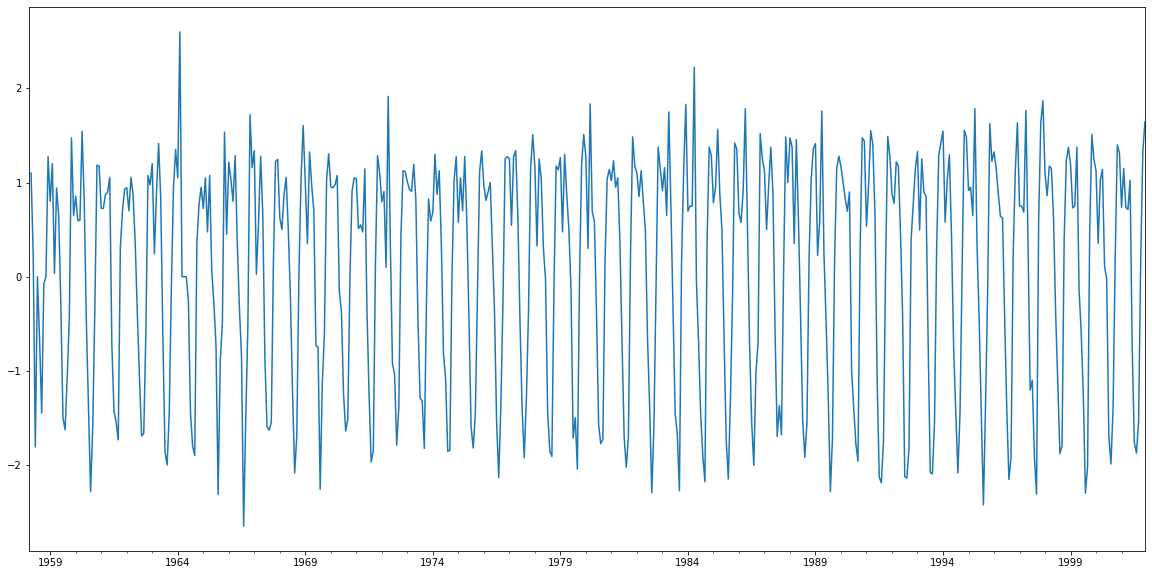

In [9]:
y.diff().plot(figsize=(20, 10))
plt.show()

## Grid search

Since we have little information about the data generating process that generates the data we are going to study, we can use a grid search to determine the set of parameters that best explains the data using a simple metric: the Akaike Information Criteria. 

The AIC is a tool we use to measure the performance of a model. By itself it does not really provide much information, but it shines when it is used to compare two or more models. 

In [10]:
# Trying out different models
m = ARIMA(y, order = (0, 1, 1))
m.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    co2   No. Observations:                  526
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -685.451
Date:                Tue, 07 Sep 2021   AIC                           1374.902
Time:                        16:10:38   BIC                           1383.429
Sample:                    03-01-1958   HQIC                          1378.241
                         - 12-01-2001                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6514      0.035     18.456      0.000       0.582       0.721
sigma2         0.7964      0.067     11.955      0.000       0.666       0.927
===================================================================================
Ljung-Box (L1) (Q):                  41.28   Jarque-Bera (JB):                19.05
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -0.24
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
m = ARIMA(y.diff()[1:], order = (0, 0, 1))
m.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    co2   No. Observations:                  525
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -684.084
Date:                Tue, 07 Sep 2021   AIC                           1374.168
Time:                        16:10:39   BIC                           1386.958
Sample:                    04-01-1958   HQIC                          1379.176
                         - 12-01-2001                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1061      0.068      1.556      0.120      -0.028       0.240
ma.L1          0.6503      0.036     18.218      0.000       0.580       0.720
sigma2         0.7922      0.066     11.950      0.000       0.662       0.922
===================================================================================
Ljung-Box (L1) (Q):                  41.73   Jarque-Bera (JB):                19.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -0.24
Prob(H) (two-sided):                  0.87   Kurtosis:                         2.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))


In [22]:
pdq[1]

(0, 0, 1)

In [23]:
for param in pdq:
        try:
            mod = ARIMA(y, order = param)

            results = mod.fit()

            print('ARIMA{}'.format(param), results.aic)
        except:
            continue

ARIMA(0, 0, 0) 4483.106593051412


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 1) 3775.873381891385
ARIMA(0, 0, 2) 3164.41268002279
ARIMA(0, 1, 0) 1678.850182235887
ARIMA(0, 1, 1) 1374.9022657047076
ARIMA(0, 1, 2) 1250.590207071741
ARIMA(0, 2, 0) 1406.805287442106
ARIMA(0, 2, 1) 1379.0344241443493
ARIMA(0, 2, 2) 1369.3274369644519
ARIMA(1, 0, 0) 1691.8798314627845
ARIMA(1, 0, 1) 1387.7270853866871
ARIMA(1, 0, 2) 1263.0705503938339
ARIMA(1, 1, 0) 1327.3523675280999
ARIMA(1, 1, 1) 1267.20200708992
ARIMA(1, 1, 2) 1222.8224935996313
ARIMA(1, 2, 0) 1377.4049298183174
ARIMA(1, 2, 1) 1378.8403215948363
ARIMA(1, 2, 2) 1270.7385619314318
ARIMA(2, 0, 0) 1338.1464763446254
ARIMA(2, 0, 1) 1278.6726745606138
ARIMA(2, 0, 2) 1234.4617304158273
ARIMA(2, 1, 0) 1205.4430955431399
ARIMA(2, 1, 1) 1075.977973445632
ARIMA(2, 1, 2) 1076.7451973642196
ARIMA(2, 2, 0) 1377.466493605761


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 2, 1) 1208.7225283528064
ARIMA(2, 2, 2) 1224.0306338815867


According to this calculation, ARIMA(2,1,1) is the best performing model in terms of AIC out of the set of possible parameters analysed. 

In [25]:

chosenarimamodel = ARIMA(y, order = (2, 1, 1))
print(chosenarimamodel.fit().summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5353      0.028     55.566      0.000       1.481       1.589
ar.L2         -0.8285      0.030    -27.249      0.000      -0.888      -0.769
ma.L1         -0.8117      0.037    -21.901      0.000      -0.884      -0.739
sigma2         0.4458      0.026     17.040      0.000       0.395       0.497


In [26]:
trainsize = int(len(y) * 0.90)
train, test = y[0:trainsize], y[trainsize:]
history = [x for x in train]
predictions = list()

In [27]:
for t in range(len(test)):
	model = ARIMA(history, order = (2,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	history.append(test[t])
	# calculate out of sample error
error = mean_squared_error(test, predictions)
print(error)

0.4867093744065652


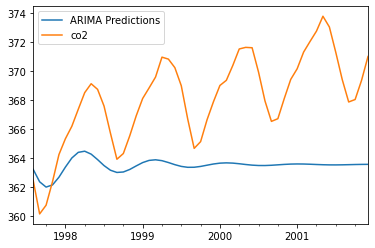

In [30]:
train = train[1:]
start=len(train)
end=len(train)+len(test)-1

testarima = ARIMA(train, order = (2, 1, 1))

pred=testarima.fit().predict(start=start,end=end).rename('ARIMA Predictions')
pred.plot(legend=True)
test.plot(legend=True)


The forecast is not great, primarily because our model does not take into consideration the clearly seasonal model of the data. 

We can expand this experiment to using the `SARIMAX` function, which allows for a seasonal component to be added to the modelling. With long and clearly seasonal datasets like this one, it might generate better results. 

## Seasonal ARIMA 

We can include a seasonal component to the estimation of the time series to incorporate the typical monthly behaviour not included in traditional ARIMA analysis. 

SARIMAX stands for _Seasonal ARIMA with Exogenous variables_. In this case we did not add anu exogenous variables to the calculations, but it's relatively straightforward to do (see Example 4 of the documentation).  

In [31]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [32]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.3436240338315
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1854.828234141261
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727643164
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320035
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878518713133
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.657897806985
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647912700677
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048754156435
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327461802
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941067014495
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.4174716862362
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1079.499039374615
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:930.5388008098283
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.595789361149
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912988850356
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1675.8086923024293
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.2211199194076
A

In [33]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.163      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.812      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.632      0.000       0.089       0.106


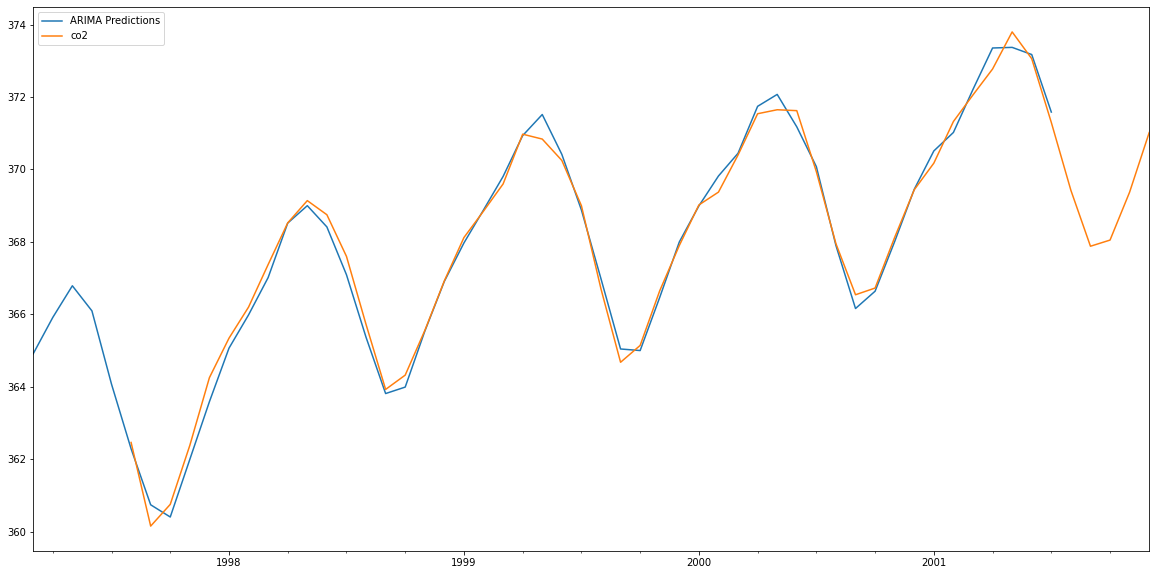

In [39]:
train = train[1:]
start=len(train)
end=len(train)+len(test)-1

testarima = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

pred=testarima.fit().predict(start=start,end=end).rename('ARIMA Predictions')
pred.plot(legend=True, figsize=(20, 10))
test.plot(legend=True)

## Some notes

- The `auto_arima` function allows for automatic grid search. Be careful of the parameters used for the estimation, since controls need to be fined tuned to replicate the results we have above. 
- We determined the best model using the AIC. There are other target functions you can use to choose your $p$, $d$, and $q$ parameters.  One possibility is the _mean square error_ between the predicted values given a set of parameters, and the test set. Jason Brownlee has excellent tutorials on how to do this. 
- An alternative way to check whether we have the right set of parameters is to check the ACF of the errors.
- We must not forget to check whether the chosen parameters to explain our model fit our understanding of the underlying data. 

## Sources

In [ ]:
# https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
# https://machinelearningmastery.com/make-sample-forecasts-arima-python/
# https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
# https://www.pluralsight.com/guides/advanced-time-series-modeling-(arima)-models-in-python
# https://people.duke.edu/~rnau/411arim.htm
# https://medium.com/swlh/temperature-forecasting-with-arima-model-in-python-427b2d3bcb53
# https://www.statsmodels.org/stable/index.html